STEP 0 — Prerequisites

In [1]:
pip install boto3 tensorflow matplotlib


Note: you may need to restart the kernel to use updated packages.


STEP 1 — Download data from S3 to current working directory

In [2]:
import boto3
import os

# -------------------------
# S3 configuration
# -------------------------
BUCKET_NAME = "ai-bmi-predictor-v2"
S3_PREFIX = "tight and loose classifier/synthetic data/Training Data/"
LOCAL_ROOT = "synthetic_data/Training Data"

# Create local root directory
os.makedirs(LOCAL_ROOT, exist_ok=True)

print("Downloading data from S3...")
print("S3 source:", f"s3://{BUCKET_NAME}/{S3_PREFIX}")
print("Local destination:", LOCAL_ROOT)

s3 = boto3.client("s3")

paginator = s3.get_paginator("list_objects_v2")

for page in paginator.paginate(Bucket=BUCKET_NAME, Prefix=S3_PREFIX):
    for obj in page.get("Contents", []):
        s3_key = obj["Key"]

        # Skip folder placeholders
        if s3_key.endswith("/"):
            continue

        # Build local file path
        relative_path = s3_key.replace(S3_PREFIX, "")
        local_file_path = os.path.join(LOCAL_ROOT, relative_path)

        # Create parent directories
        os.makedirs(os.path.dirname(local_file_path), exist_ok=True)

        # Download file
        s3.download_file(BUCKET_NAME, s3_key, local_file_path)

print("Download completed successfully ✅")


S3 source: s3://ai-bmi-predictor-v2/tight and loose classifier/synthetic data/Training Data/
Local destination: synthetic_data/Training Data
Download completed successfully ✅


STEP 2 — Verify downloaded data

In [3]:
import os

tight_path = "synthetic_data/Training Data/Tight"
loose_path = "synthetic_data/Training Data/Loose"

print("Tight images:", len(os.listdir(tight_path)))
print("Loose images:", len(os.listdir(loose_path)))


Tight images: 1000
Loose images: 1000


STEP 3 — Training configuration

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("TensorFlow version:", tf.__version__)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 300

train_dir = "synthetic_data/Training Data"
print("Training directory:", train_dir)


2025-12-23 14:42:05.606755: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-23 14:42:05.622501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-23 14:42:05.646968: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-23 14:42:05.646997: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-23 14:42:05.661693: I tensorflow/core/platform/cpu_feature_gua

TensorFlow version: 2.16.2
Training directory: synthetic_data/Training Data


STEP 4 — Load data (20% validation split, no augmentation)

In [5]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

print("Class indices:", train_generator.class_indices)


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Class indices: {'Loose': 0, 'Tight': 1}


STEP 5 — Build MobileNetV2 model

In [6]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

print("MobileNetV2 base layers frozen")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.summary()


2025-12-23 14:42:07.970598: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-23 14:42:11.288314: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-23 14:42:11.291495: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

9406464/9406464 [==============================] - 1s 0us/step
MobileNetV2 base layers frozen
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  


STEP 6 — Compile model

In [7]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[BinaryAccuracy(name="accuracy", threshold=0.5)]
)

print("Model compiled successfully")


Model compiled successfully


STEP 7 — Callbacks

In [8]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=5,
    min_lr=1e-7,
    verbose=1
)


STEP 8 — Train model

In [9]:
print("Training started...")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

print("Training completed")


Training started...
Epoch 1/300


2025-12-23 14:42:39.211530: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1766500977.100752   13475 service.cc:145] XLA service 0x7ff5c0b39fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766500977.100787   13475 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-12-23 14:42:57.379043: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 1/50 [..............................] - ETA: 35:14 - loss: 0.7661 - accuracy: 0.5000

I0000 00:00:1766500977.960176   13475 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 [==============================] - 54s 212ms/step - loss: 0.4866 - accuracy: 0.7663 - val_loss: 0.2478 - val_accuracy: 0.9175 - lr: 1.0000e-04
Epoch 2/300
50/50 [==============================] - 5s 109ms/step - loss: 0.2510 - accuracy: 0.9100 - val_loss: 0.1711 - val_accuracy: 0.9250 - lr: 1.0000e-04
Epoch 3/300
50/50 [==============================] - 6s 110ms/step - loss: 0.1837 - accuracy: 0.9306 - val_loss: 0.1360 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 4/300
50/50 [==============================] - 6s 109ms/step - loss: 0.1394 - accuracy: 0.9513 - val_loss: 0.1040 - val_accuracy: 0.9850 - lr: 1.0000e-04
Epoch 5/300
50/50 [==============================] - 6s 110ms/step - loss: 0.1255 - accuracy: 0.9569 - val_loss: 0.0871 - val_accuracy: 0.9850 - lr: 1.0000e-04
Epoch 6/300
50/50 [==============================] - 6s 110ms/step - loss: 0.0980 - accuracy: 0.9656 - val_loss: 0.0746 - val_accuracy: 0.9825 - lr: 1.0000e-04
Epoch 7/300
50/50 [==============================] 

STEP 9 — Save model

In [10]:
model.save("clothes_classifier_mobilenetv2.h5")
print("Model saved as clothe_classifier.h5")


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as clothe_classifier.h5


STEP 10 — Plot loss & accuracy

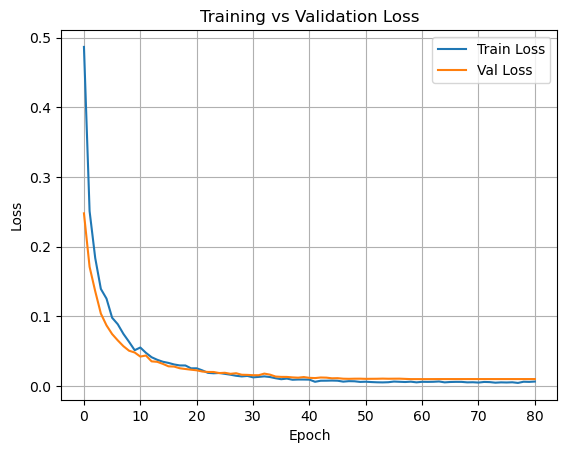

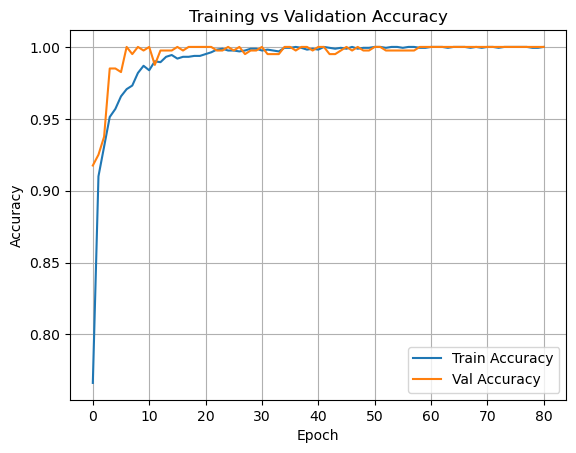

In [11]:
# Loss plot
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy plot
plt.figure()
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()
